In [1]:
from modules.models import travelKawaharaPINN, create_dense_model
from modules.data import simulate_travel_kawahara
from modules.plots import plot_KdV_model, plot_training_loss
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


2023-05-19 15:55:14.693243: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2023-05-19 15:55:27.144649: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


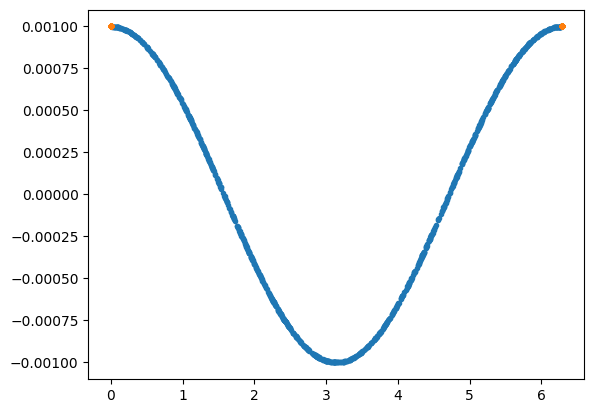

In [2]:
x_start = 0
length = 2*np.pi
time = np.pi / 2


(tx_eqn, y_eqn, u_exact), (tx_init, y_init), (tx_boundary, y_boundary),solution = \
    simulate_travel_kawahara(1000, x_start, length , time , random_seed = 42, dtype=tf.float32) 

21
[ -6.90775528          nan -23.61363801          nan -42.57431513]
4.9554893444985375e-89
[False False False False False False False False False False False False
 False False False False False False False False False False False]


/var/folders/8f/ms98g78j5vz0vnknq4rmjbwm0000gn/T/ipykernel_94662/3907077494.py:4: RuntimeWarning: invalid value encountered in log
  print(np.log(solution[2::])[0:5])


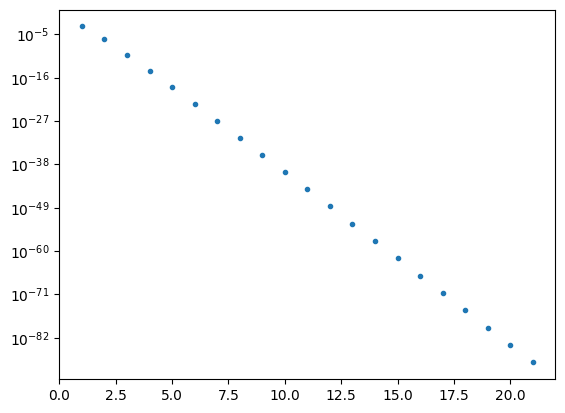

In [3]:
n = np.arange(1,22,1)
print(len(solution[2::]))
plt.semilogy(n,np.abs(solution[2::]),'.')
print(np.log(solution[2::])[0:5])
print(solution[-1])
print(np.isnan(solution))

In [10]:
inputs = [tx_eqn, tx_init, tx_boundary]
outputs = [u_exact, y_eqn, y_init, y_boundary]

In [11]:
backbone = create_dense_model([64, 64, 64], activation='tanh', initializer='glorot_normal', \
    n_inputs=2, n_outputs=1)

In [12]:
solution[0]

0.7500009999995948

In [13]:
pinn = travelKawaharaPINN(backbone, c=solution[0], alpha = 1.0, beta= 1/4 ,sigma = 1.0)
scheduler = tf.keras.optimizers.schedules.ExponentialDecay(1e-3, decay_steps=500, decay_rate=0.92)
optimizer = tf.keras.optimizers.Adam(learning_rate=scheduler)
pinn.compile(optimizer=optimizer)

In [18]:
history = pinn.fit_custom(inputs, outputs, epochs=20000, print_every=1000)

RuntimeError: in user code:

    File "/Users/nadiaaiaseh/Desktop/Trunk/PinnNew/modules/models.py", line 1987, in train_step  *
        u_colloc_pred, residual_pred, u_init_pred, u_bnd_pred = self(
    File "/Users/nadiaaiaseh/Library/Python/3.9/lib/python/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/var/folders/8f/ms98g78j5vz0vnknq4rmjbwm0000gn/T/__autograph_generated_filezin116gc.py", line 36, in tf__call
        u_5x = ag__.converted_call(ag__.ld(tape4).batch_jacobian, (ag__.ld(u_4x), ag__.ld(tx_colloc)), None, fscope)[..., 1]

    RuntimeError: Exception encountered when calling layer 'travel_kawahara_pinn_1' (type travelKawaharaPINN).
    
    in user code:
    
        File "/Users/nadiaaiaseh/Desktop/Trunk/PinnNew/modules/models.py", line 1962, in call  *
            u_5x = tape4.batch_jacobian(u_4x, tx_colloc)[..., 1]
    
        RuntimeError: A non-persistent GradientTape can only be used tocompute one set of gradients (or jacobians)
    
    
    Call arguments received by layer 'travel_kawahara_pinn_1' (type travelKawaharaPINN):
      • inputs=['tf.Tensor(shape=(1000, 2), dtype=float32)', 'tf.Tensor(shape=(1000, 2), dtype=float32)', 'tf.Tensor(shape=(1000, 2), dtype=float32)']
      • training=True


In [ ]:
plot_training_loss(history.history, y_scale='log')

In [ ]:
plot_KdV_model(pinn.backbone, x_start,length, time, save_path = None, show=True) 

In [ ]:
def plot_snapshots(timeList,num_test_samples = 1000):
    x_flat = np.linspace(x_start, length, num_test_samples)
    t_flat = np.linspace(0, time, num_test_samples)
    t_cross_sections = timeList
    for i, t_cs in enumerate(t_cross_sections):
        tx = np.stack([np.full(t_flat.shape, t_cs), x_flat], axis=-1)
        u = pinn.backbone.predict(tx, batch_size=num_test_samples)
        plt.plot(x_flat, u, label = 'prediction')
        plt.plot(x_flat, u_exact, label = 'exact')
        plt.legend()
        plt.title('t={}'.format(np.round(t_cs,2)))
        plt.xlabel('x')
        plt.ylabel('u(t,x)')
        return